Use this notebook to run 1 denoiser step and get updated intermediate steps

In [1]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # needed to make torch deterministic

In [2]:
import torch
from torch.testing import assert_close
from torch import allclose, nn, tensor
torch.set_printoptions(linewidth=200)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Load the model

In [4]:
from diffusers import StableDiffusionPipeline
from diffusers import DDIMScheduler
from diffusers import ControlNetXSModel
from diffusers import StableDiffusionControlNetXSPipeline

Info: `UmerDebugLogger` created. This is a logging class that will be deleted when the PR to integrate ControlNet-XS is done.


In [5]:
sd_pipe = StableDiffusionPipeline.from_single_file('weights/sd/sd21/v2-1_512-ema-pruned.ckpt').to(device)
cnxs = ControlNetXSModel.from_pretrained('weights/cnxs_diffusers/sd21-canny').to(device)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
/home/diffusers/src/diffusers/configuration_utils.py:135: FutureWarning: Accessing config attribute `requires_safety_checker` directly via 'StableDiffusionPipeline' object attribute is deprecated. Please access 'requires_safety_checker' over 'StableDiffusionPipeline's config object instead, e.g. 'scheduler.config.requires_safety_checker'.
  depre

For Heidelberg **SD 2.1** we change the scheduler to `DDIMScheduler` (by default it's `PNDMScheduler`), but keep all settings (if applicable). Except (!) `prediction_type` which we set to `epsilon`.

In [6]:
scheduler_dict = dict(DDIMScheduler().config)
for k,v in sd_pipe.scheduler.config.items():
    if k in scheduler_dict: scheduler_dict[k]=v
scheduler_dict['prediction_type'] = 'epsilon'

sd_pipe.scheduler = DDIMScheduler(**scheduler_dict)

assert sd_pipe.scheduler.config.prediction_type == 'epsilon'

In [7]:
cnxs_pipe = StableDiffusionControlNetXSPipeline(
    vae=sd_pipe.vae,
    text_encoder=sd_pipe.text_encoder,
    tokenizer=sd_pipe.tokenizer,
    unet=sd_pipe.unet,
    controlnet=cnxs,
    scheduler=sd_pipe.scheduler,
    safety_checker=sd_pipe.safety_checker,
    feature_extractor=sd_pipe.feature_extractor
)

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet_xs.pipeline_controlnet_xs.StableDiffusionControlNetXSPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


___

## Run 1 step locally

In [8]:
import torch
import random
import numpy as np
import cv2
from diffusers.utils import load_image
import matplotlib.pyplot as plt

class CannyDetector:
    def __call__(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

def get_canny_edges(image, threshold=(100, 250)):
    image = np.array(image).astype(np.uint8)
    edges = CannyDetector()(image, *threshold)  # original sized greyscale edges
    edges = edges / 255.
    return edges

def seed_everything(seed):
    # paper used deprecated `seed_everything` from pytorch lightning
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

RANDOM_SEED_IN_PAPER = 1999158951

In [9]:
latents_sd_cloud = torch.load('latents_cloud_no_control_512.pth', map_location=torch.device(device))

rand_from_cloud = latents_sd_cloud

print(f'Loaded random noise has shape {rand_from_cloud.shape}, and distribution {rand_from_cloud.mean().item():.6f} ± {rand_from_cloud.std().item():.6f}')

Loaded random noise has shape torch.Size([1, 4, 64, 64]), and distribution -0.005805 ± 1.008855


In [10]:
prompt = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
neg_prompt = 'lowres, bad anatomy, worst quality, low quality'

def get_image(path, size):
    import torchvision.transforms as tt
    
    image = load_image(path)
    image = tt.CenterCrop(size)(tt.Resize(size)(image))
    return image
    
image = get_image('input_images/shoe.png', 512)
edges = get_canny_edges(image)

edges_tensor = torch.tensor(edges)
three_edges = torch.stack((edges_tensor,edges_tensor,edges_tensor)).unsqueeze(0)
three_edges.shape

torch.Size([1, 3, 512, 512])

In [11]:
from diffusers.umer_debug_logger import udl

In [12]:
#udl.set_dir('logs/local_cuda', clear=True)
#udl.set_condition('STEP')

In [13]:
seed_everything(RANDOM_SEED_IN_PAPER)
result = cnxs_pipe(
    prompt,
    negative_prompt=neg_prompt,image=three_edges, 
    latents=rand_from_cloud,
    controlnet_conditioning_scale=0.95,
    guidance_scale=9.5,
    eta=0.5,
    use_fixed_noise=True
)

  0%|          | 0/50 [00:00<?, ?it/s]

Info: No condition set for UmerDebugLogger


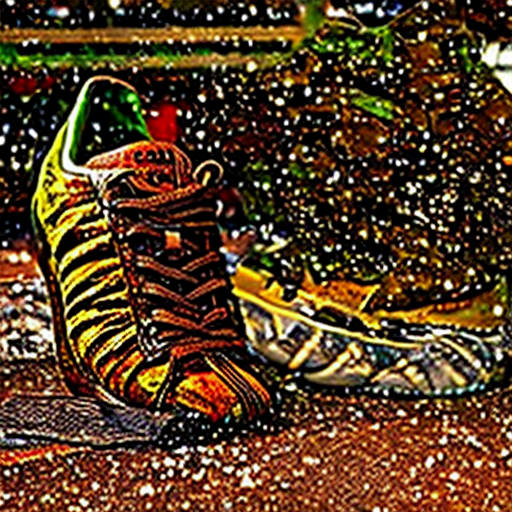

In [14]:
result.images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

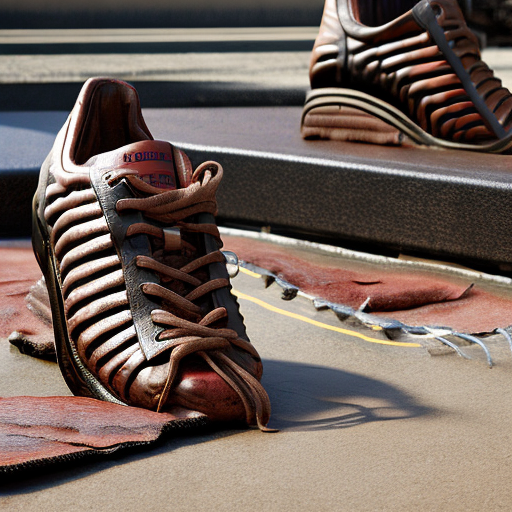

In [15]:
seed_everything(RANDOM_SEED_IN_PAPER)
result_1 = cnxs_pipe(
    prompt,
    negative_prompt=neg_prompt,image=three_edges, 
#    latents=rand_from_cloud,
    controlnet_conditioning_scale=0.95,
    guidance_scale=9.5,
    eta=0.5,
#    use_fixed_noise=True
)
result_1.images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

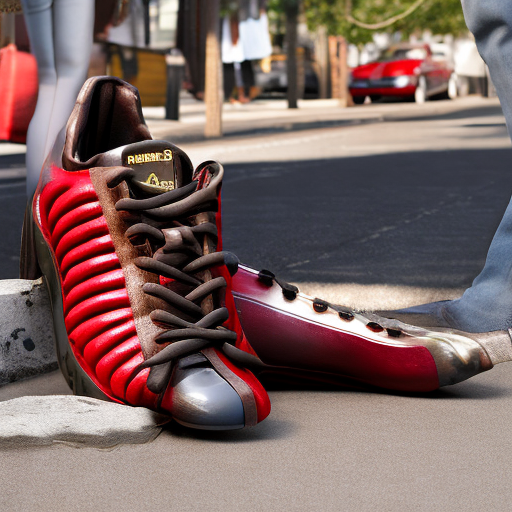

In [16]:
#seed_everything(RANDOM_SEED_IN_PAPER)
result_2 = cnxs_pipe(
    prompt,
    negative_prompt=neg_prompt,image=three_edges, 
#    latents=rand_from_cloud,
    controlnet_conditioning_scale=0.95,
    guidance_scale=9.5,
    eta=0.5,
#    use_fixed_noise=True
)
result_2.images[0]

In [17]:
assert False

AssertionError: 

In [18]:
ims = [
    cnxs_pipe(
        prompt,
        negative_prompt=neg_prompt,image=three_edges, 
        controlnet_conditioning_scale=0.95,
        guidance_scale=9.5,
        eta=0.5,
    ).images[0]
    for _ in range(10)
]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[<PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>]

In [23]:
from IPython.display import display

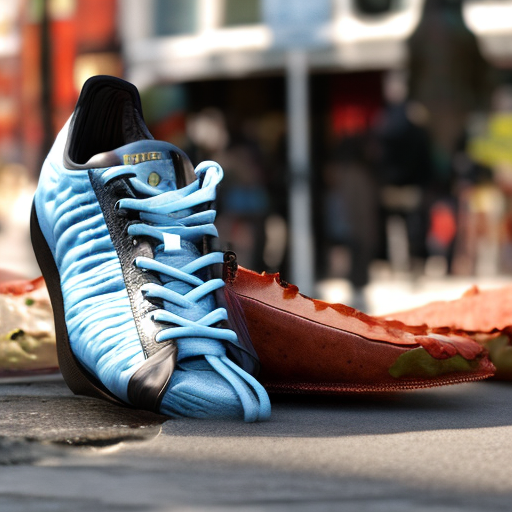

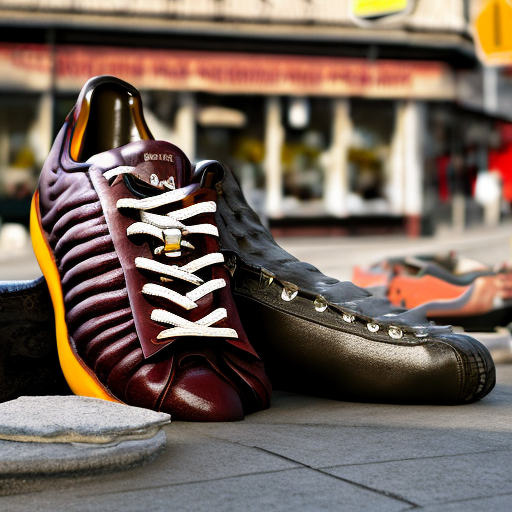

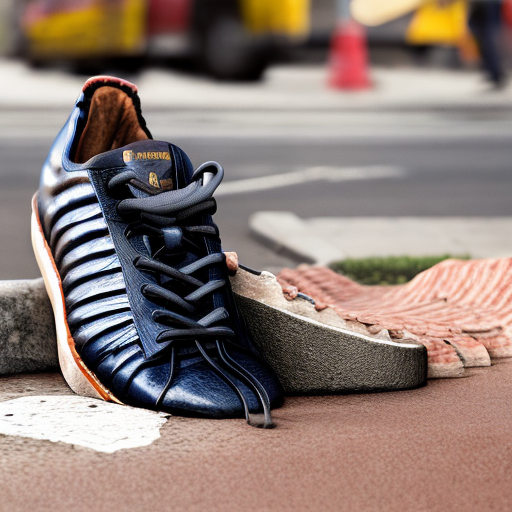

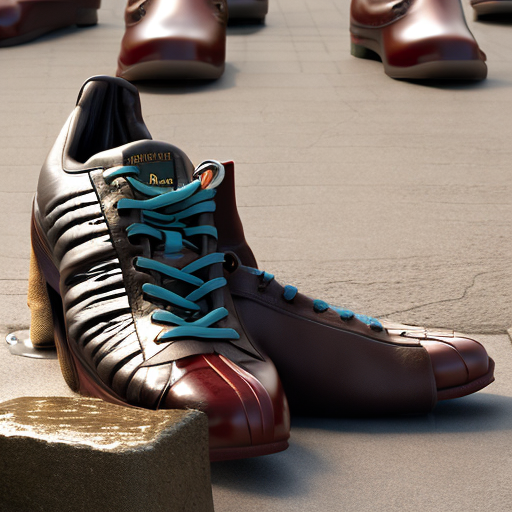

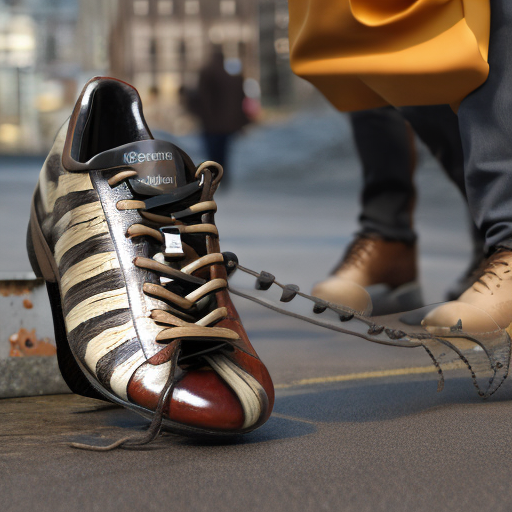

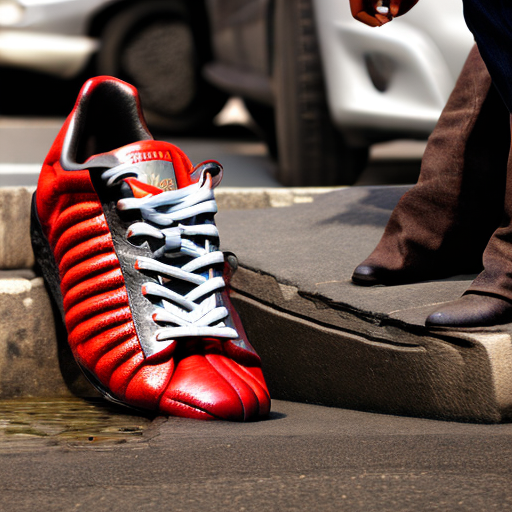

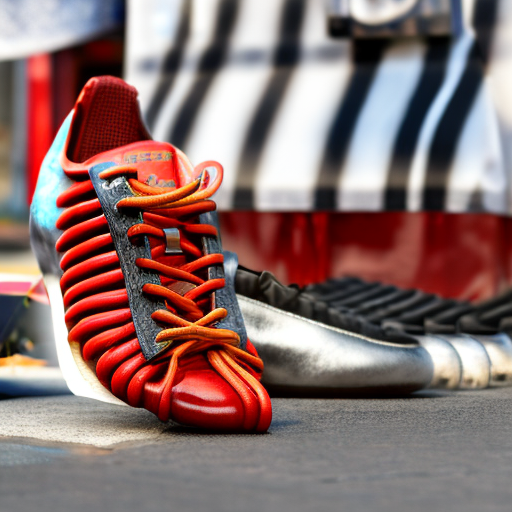

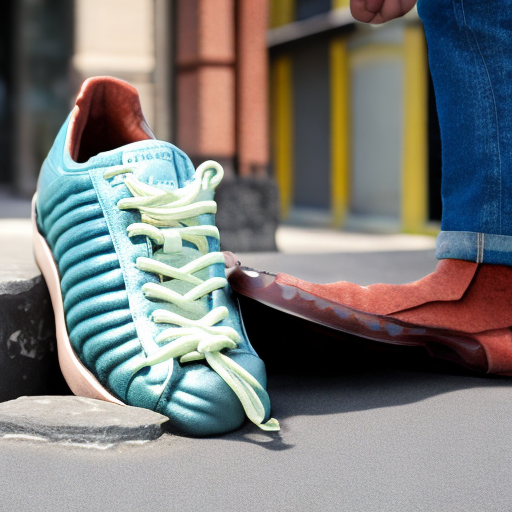

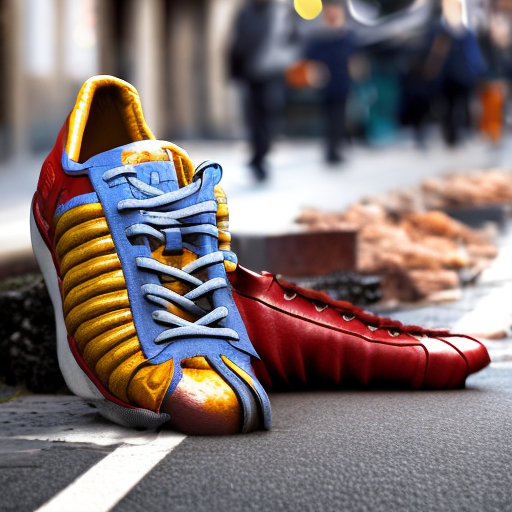

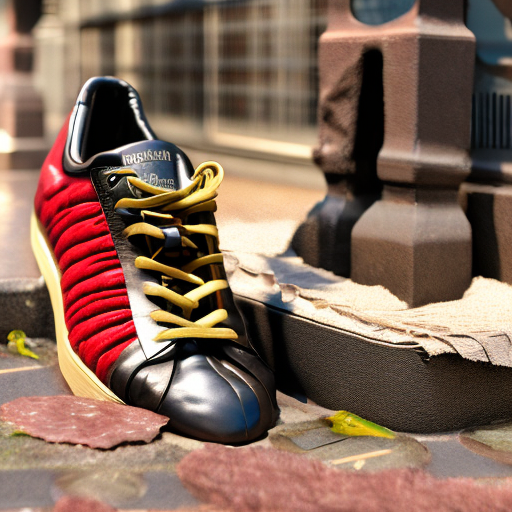

In [24]:
for im in ims: display(im)

Convert pipe and latents to cpu, as we otherwise get an cuda oom error when decoding the image after each denoising step

In [ ]:
def to_cpu(t): return t.cpu() if hasattr(t,'cpu') else t
def only_lat(l): return l[-1]

In [ ]:
lats = [to_cpu(only_lat(l)) for l in lats]

In [ ]:
pipe=cnxs_pipe.to('cpu')

In [ ]:
lats[0].device

In [ ]:
import einops
import numpy as np
from PIL import Image

def lat2img(lat, pipe, resize_to=None, output_type='pil'):
    with torch.no_grad():
        if lat.dim()==3: lat = lat.unsqueeze(0) # add batch dimension        
        ims = pipe.vae.decode(lat / pipe.vae.config.scaling_factor, return_dict=False)[0]
        ims = pipe.image_processor.postprocess(ims, output_type=output_type)
        
        if resize_to is not None:
            if output_type=='pil': ims = [im.resize(resize_to) for im in ims]
            else: print(f'Not resizing as output_type = {output_type} requested')
    return ims

In [ ]:
from functools import partial
from tqdm.notebook import tqdm

import torch
import einops
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageDraw
from tqdm.notebook import tqdm
from functools import partial

def plot_latents_to_pil_grid(lats, pipe, every=1, cols=10, im_size=200, pbar=True, border=2, return_ims=True, output_type='pil'):
    if not isinstance(im_size, (list, tuple)): im_size = (im_size, im_size)
    
    lats = [lat for i, lat in enumerate(lats) if i % every == 0 or i == len(lats)-1]
    if pbar: lats = tqdm(lats)
    
    # decoce latents -> images
    ims = [lat2img(lat, pipe, resize_to=im_size, output_type=output_type)[0] for lat in lats] # removed pipe argument
    
    # add border
    ims_bordered = [ImageOps.expand(im, border=2, fill='black') for im in ims]
    im_size = (im_size[0]+border, im_size[1]+border)

    rows = len(ims) // cols
    if rows * cols < len(ims): rows += 1

    # draw background
    grid_image = Image.new('RGB', (cols * im_size[0], rows * im_size[1]), color='grey')
    draw = ImageDraw.Draw(grid_image)
    for xy in range(0,2*max(cols * im_size[0], rows * im_size[1])+1,100):
        draw.line([(xy, 0), (0, xy)], fill="white", width=1)
    
    # draw images
    for i, img in enumerate(ims_bordered):
        x_offset = (i % cols) * im_size[0]
        y_offset = (i // cols) * im_size[1]
        grid_image.paste(img, (x_offset, y_offset))

    if return_ims: return grid_image, ims
    else: return grid_image

In [ ]:
type(lats)

In [ ]:
grid, ims = plot_latents_to_pil_grid(lats, pipe=pipe)

In [ ]:
grid

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis('off')
plt.show()